In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

# Testing Assumptions

Usually, you will start with empirical data.

You might have educated guesses about the distributions, but you are often not sure.

Let's see how to test this.

## Preprocess
First, we preprocess the penguins data so that we only have the floating point data for continuous distributions

Jupyter notebook will search in our kernel for packages, but it won't know where to find our own src package. But we can add our current working directory with `"."` to `sys.path`, which lists all the locations where python will try to find packages.

If you are curious, just print `sys.path` to have a look.

In [28]:
import sys
sys.path.insert(0, ".")
from src.settings import modelsettings
from src import preprocess

In [29]:
modelsettings

Models(processed_dir=PosixPath('data/processed'), target='species')

In [30]:
filename = ("../.." / modelsettings.processed_dir / "processed.parq").resolve()
p = preprocess.prepare_floats(filename, modelsettings)

Now, we have melted and normalized data.


## Visualize

<AxesSubplot:xlabel='variable', ylabel='norm'>

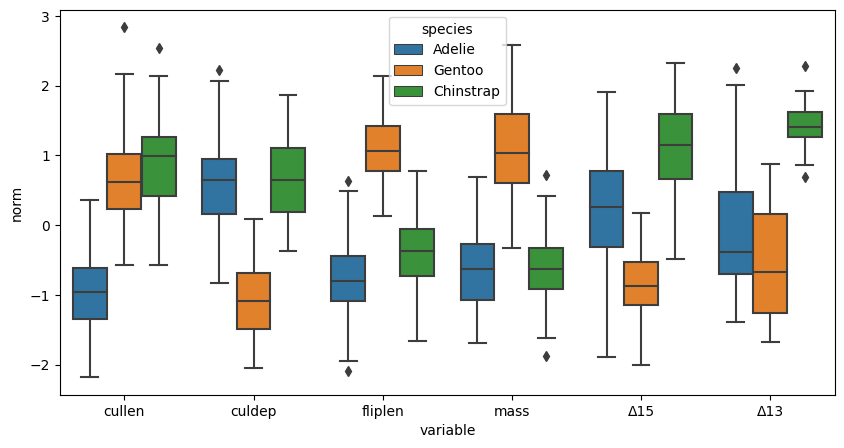

In [31]:

plt.figure(figsize=(10,5))
sns.boxplot(data = p.to_pandas(), x = 'variable', y='norm', hue='species')

Are this normal distributions?

<AxesSubplot:xlabel='norm', ylabel='Density'>

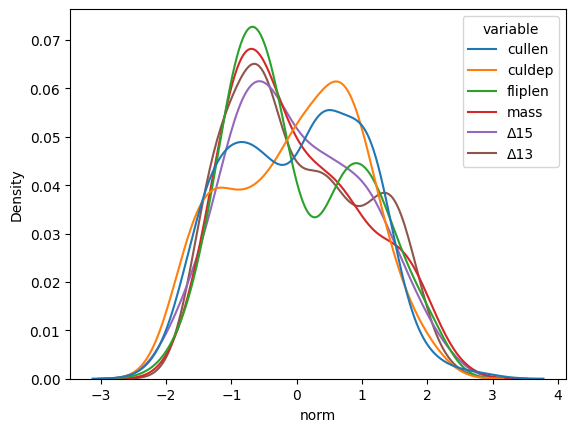

In [32]:

sns.kdeplot(p.to_pandas(), x="norm", hue="variable")

Maybe, maybe not...

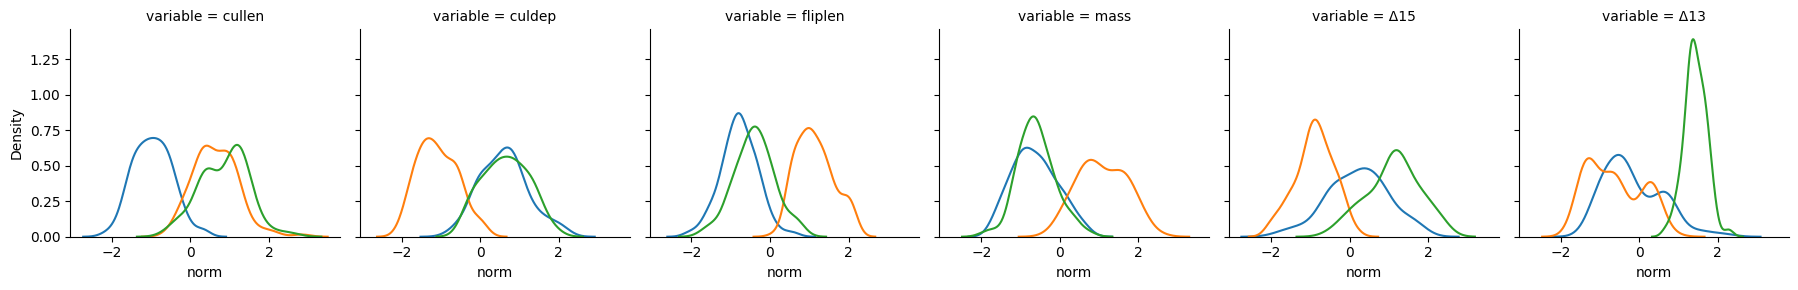

In [33]:
g = sns.FacetGrid(p.to_pandas(), col="variable", hue="species")
g.map_dataframe(sns.kdeplot, x="norm")

Regardless of the type of distribution, we can still indicate how easy it will be to separate, for example, species.

## Testing distributions

Let's select, from the species "Adelie", the length of the flipper.


In [34]:
vars = p.select(pl.col("variable").unique())["variable"].to_list()
vars

['Δ15', 'culdep', 'mass', 'cullen', 'Δ13', 'fliplen']

In [35]:
x = p.filter((pl.col("variable") == "fliplen") & (pl.col("species") == "Adelie"))["norm"].to_list()

Now we can use the `Fitter` library to fit a distribution.
Let's test these four distrubutions:

In [36]:

from fitter import Fitter, get_common_distributions
d = ["uniform", "lognorm", "norm", "gamma"] 
d


['uniform', 'lognorm', 'norm', 'gamma']

Now we fit, and make a summary.

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 57.58it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,50.740715,321.248936,-130.207646,inf,0.070042,0.481357
gamma,50.747970,322.729881,-125.253299,inf,0.072333,0.440483
lognorm,50.748393,322.729794,-125.252142,inf,0.072600,0.435837
uniform,60.325404,204.296888,-106.157218,inf,0.224725,0.000001


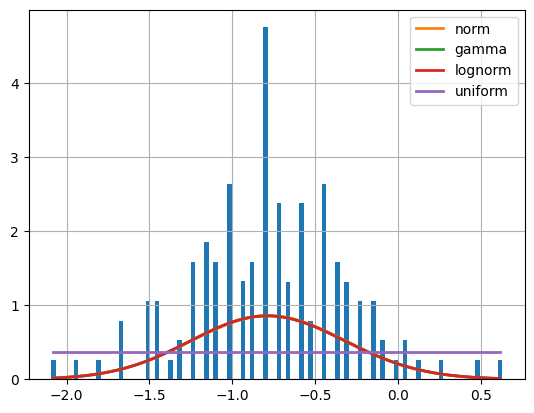

In [37]:
f = Fitter(x, distributions=d)
f.fit()
f.summary()

You can also get the parameters of the best fit:

In [38]:
f.get_best()

{'norm': {'loc': -0.7803249570923259, 'scale': 0.46509198210729097}}

Or from all of them:

In [39]:
f.fitted_param

{'uniform': (-2.0930377377314215, 2.7223199479135074),
 'norm': (-0.7803249570923259, 0.46509198210729097),
 'gamma': (3460.1727743420906, -28.13842673589476, 0.007906558126547933),
 'lognorm': (0.01173808172531246, -40.40058066449612, 39.61726222855667)}

Fitter uses the pylab backend hardcoded. But we can hack the fitter object, by studying the [source code](https://fitter.readthedocs.io/en/latest/_modules/fitter/fitter.html#Fitter).

- There is a `self.get_best()` method that provides the parameters of the best fit.
- `self._data` provides us with the raw data for the historgram
- We can use `self.df_errors` to get a dataframe of the best fits. If we sort it, we can obtain the top 5 distributions.
- `plt.plot(f.x, f.fitted_pdf[name])` gives us the fitted pdf. `name` should be the name of the distribution.


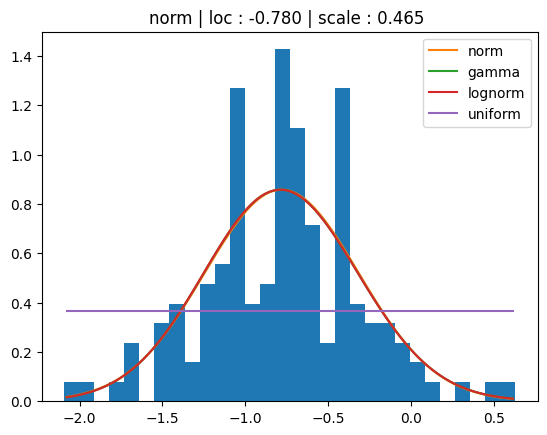

In [40]:
from src import visualization
fig, ax = plt.subplots()
visualization.custom_summary(f, ax)

This gives almost the same result, but we have more control over the details.

As you can see, the distributions are sort of close. But most probable, a normal distribution in this case.

Another, more informal way to check, is with a qq-plot (quantile-quantile plot) to visually test how the samples compare to the theoretical output for a normal distribution.

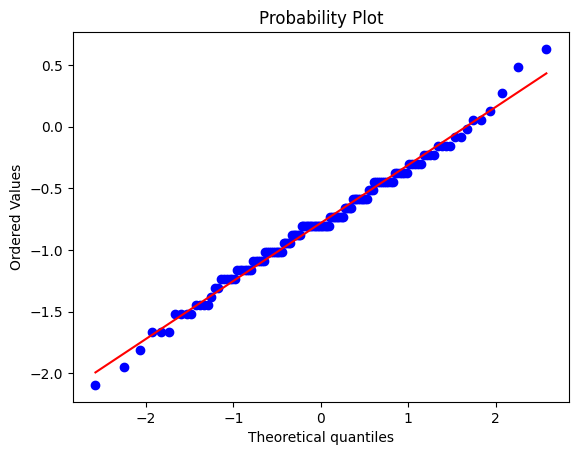

In [41]:
from scipy import stats
stats.probplot(x, dist="norm", plot=plt);

You can see there are still some outliers at the end. A perfect fit would line up along the red line.

Wrapping this:

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 50.83it/s]
/Users/raoulgrouls/code/DME22/notebooks/les3/./src/visualization.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


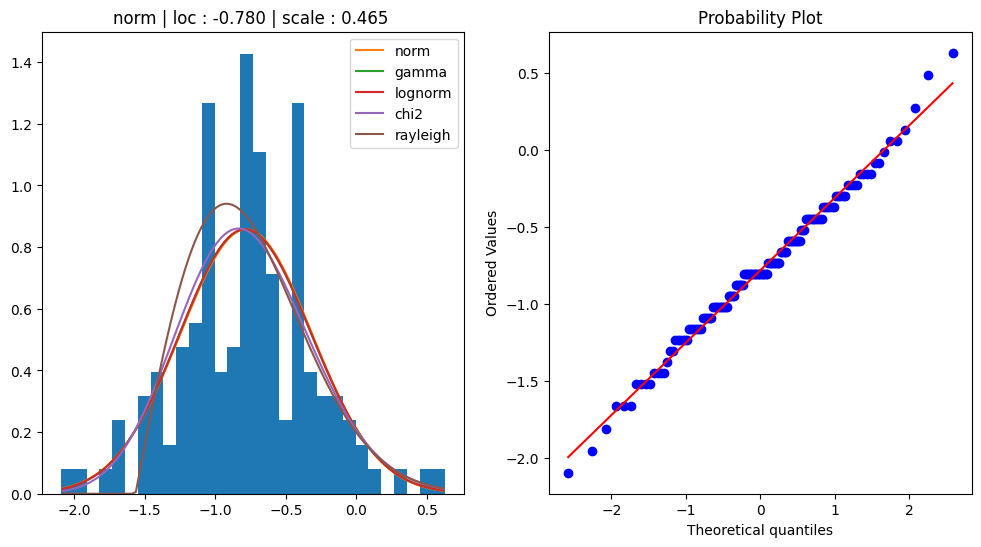

In [42]:

visualization.test_distribution(x)

That is confirmative for a normal distribution.
Now, let's try the same for one of the bloodlevel values, $\Delta 13$.

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 64.19it/s]
/Users/raoulgrouls/code/DME22/notebooks/les3/./src/visualization.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


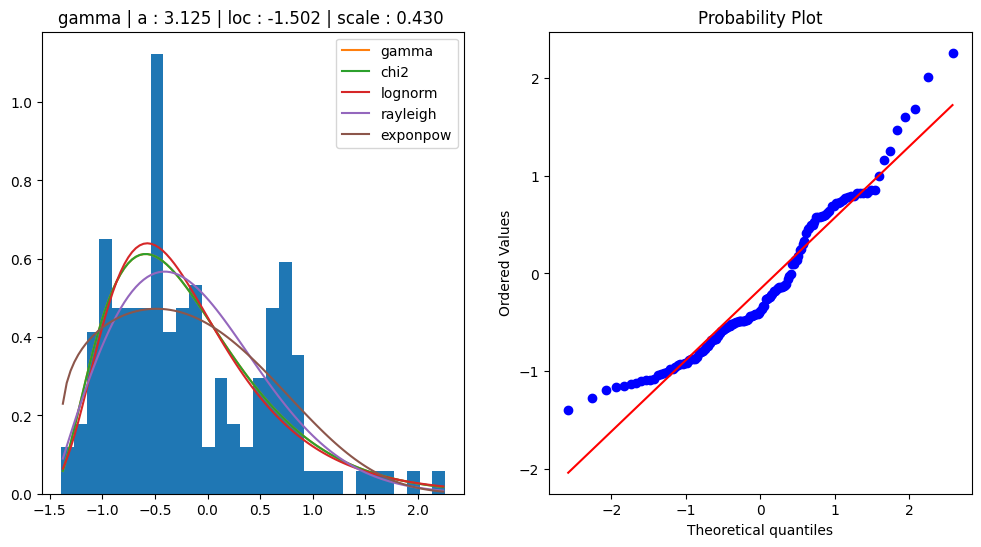

In [43]:
x = p.filter((pl.col("variable") == 'Δ13') & (pl.col("species") == "Adelie"))["norm"].to_list()
f = visualization.test_distribution(x)

As you can see, the normal distribution is not even in the top 5!

You should be carefull, however, to just pick the number 1...

In [44]:
f.df_errors.sort_values(by="sumsquare_error")

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,6.857928,357.627796,-403.457113,inf,0.078631,3.387118e-01
chi2,6.857934,357.628183,-403.456983,inf,0.078631,3.387131e-01
lognorm,6.905524,361.342272,-402.495749,inf,0.084093,2.641820e-01
rayleigh,7.167799,365.693398,-402.248722,inf,0.103303,9.585179e-02
exponpow,7.335612,353.915230,-394.097469,inf,0.090220,1.956795e-01
cauchy,7.656823,421.952919,-393.074918,inf,0.140366,7.493841e-03
norm,7.947178,394.144677,-387.901382,inf,0.128872,1.795437e-02
expon,10.239794,341.817981,-352.669800,inf,0.184398,1.308951e-04
powerlaw,10.413534,271.252515,-345.396674,inf,0.255003,1.863435e-08
uniform,10.714862,262.940049,-346.366119,inf,0.325995,1.183334e-13


As you can see, the top 3 is pretty close. A gamma distribution has 4 parameters, so that is what makes it really flexible. 

A lognormal could be a good pick here, but I would prefer to dive deeper into the underlying groups. It could be that the distribution returns to two normal distributions, for example if you split the data into male/female.

Also, I would want to talk to an expert about what is going on, to find out if this makes sense.

However, the most important conclusion: this is NOT a normal distribution, and you can't use anything that assumes a normal distribution!